In [ ]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

# Amplitude model with sum notation

```{spec} Amplitude model with sum notation
:id: TR-014
:links: TR-013; TR-015
:status: Implemented
:tags: sympy
```

```{autolink-skip}
```

In [ ]:
%pip install -q git+https://github.com/ComPWA/ampform@3ed3ed5 qrules[viz]==0.9.7 sympy==1.9

In [ ]:
from __future__ import annotations

import inspect
import itertools
import logging
from functools import lru_cache
from typing import Iterable, Sequence

import ampform
import attrs
import graphviz
import qrules
import symplot
import sympy as sp
from ampform.dynamics.builder import (
    ResonanceDynamicsBuilder,
    create_non_dynamic,
    create_relativistic_breit_wigner,
)
from ampform.helicity import (
    _generate_kinematic_variable_set,
    _generate_kinematic_variables,
)
from ampform.helicity.decay import TwoBodyDecay
from ampform.sympy import (
    UnevaluatedExpression,
    create_expression,
    implement_doit_method,
)
from IPython.display import Math, display
from qrules.topology import Topology
from qrules.transition import StateTransition
from sympy.core.symbol import Str
from sympy.physics.quantum.spin import Rotation as Wigner
from sympy.printing.latex import LatexPrinter
from sympy.printing.precedence import PRECEDENCE

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.ERROR)

(tr-014-problem)=
## Problem description

:::{admonition} Challenge
:class: purple

Formulate the [`HelicityModel`](https://ampform.readthedocs.io/en/stable/api/ampform.helicity.html#ampform.helicity.HelicityModel) in such a way that:

1. The sum over the amplitudes is concise and expresses that the sum depends only on helicities.
2. It is the {class}`sympy.Expr <sympy.core.expr.Expr>` of the amplitude model can easily and uniquely be constructed from the data in the [`HelicityModel`](https://ampform.readthedocs.io/en/stable/api/ampform.helicity.html#ampform.helicity.HelicityModel). (Currently, this is as simple as {meth}`HelicityModel.expression.doit <sympy.core.basic.Basic.doit>`).
3. All parameters under [`parameter_defaults`](https://ampform.readthedocs.io/en/stable/api/ampform.helicity.html#ampform.helicity.HelicityModel.parameter_defaults) are of type {class}`sympy.Symbol <sympy.core.symbol.Symbol>`. This is important for a correct lambdification of the arguments with {func}`sympy.utilities.lambdify.lambdify`.

This report presents two solutions:
- {ref}`tr-014-solution-1`
- {ref}`tr-014-solution-2`

:::

[ampform#245](https://github.com/ComPWA/ampform/pull/245) implements spin alignment, which results in large sum combinatorics for all helicity combinations. The result is an amplitude model expression that is too large to be rendered as LaTeX.

To some extend, this is already the case with the [current implementation](https://ampform.readthedocs.io/en/0.12.3/usage/formalism.html) of the 'standard' helicity formalism {cite}`jacobGeneralTheoryCollisions1959, richmanExperimenterGuideHelicity1984, kutschkeAngularDistributionCookbook1996, chungSpinFormalismsUpdated2014`: many of the terms in the total intensity expression differ only by the helicities of the final and initial state.

In [ ]:
# Simplify resonance notation
PDG = qrules.load_pdg()
delta_res = PDG["Delta(1600)++"]
lambda_res = PDG["Lambda(1405)"]
particles = set(PDG)
particles.remove(delta_res)
particles.remove(lambda_res)
particles.add(attrs.evolve(delta_res, latex=R"\Delta"))
particles.add(attrs.evolve(lambda_res, latex=R"\Lambda"))
MODIFIED_PDG = qrules.ParticleCollection(particles)

In [ ]:
reaction = qrules.generate_transitions(
    initial_state="Lambda(c)+",
    final_state=["K-", "p", "pi+"],
    formalism="helicity",
    allowed_intermediate_particles=["Delta(1600)++"],
    particle_db=MODIFIED_PDG,
)

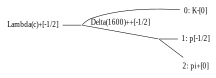

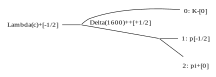

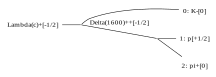

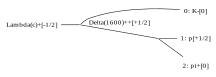

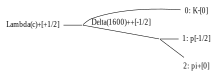

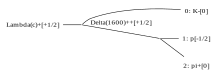

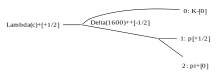

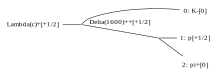

In [ ]:
display(
    *map(
        lambda t: graphviz.Source(qrules.io.asdot(t, size=3)),
        reaction.transitions,
    )
)

In [ ]:
builder = ampform.get_builder(reaction)
model = builder.formulate()

In [ ]:
def remove_coefficients(expr: sp.Expr) -> sp.Expr:
    coefficients = {s: 1 for s in expr.free_symbols if s.name.startswith("C_")}
    return expr.subs(coefficients)


model = builder.formulate()
full_expression = remove_coefficients(model.expression)
I = sp.Symbol("I")  # noqa: E741
latex = sp.multiline_latex(I, full_expression)
Math(latex)

<IPython.core.display.Math object>

Here, we did not insert any dynamics, but it is unusual that dynamics expressions depend on helicity or spin projection (see [`TwoBodyKinematicVariableSet`](https://ampform.readthedocs.io/en/stable/api/ampform.dynamics.builder.html#ampform.dynamics.builder.TwoBodyKinematicVariableSet)).

## Simplified notation with `PoolSum`

Both {ref}`tr-014-solution-1` and {ref}`tr-014-solution-2` require the definition of a special "`PoolSum`" class to simplify the summation over the amplitudes. The class mimics {class}`sympy.Sum <sympy.concrete.summations.Sum>` in that it substitutes certain {class}`~sympy.core.symbol.Symbol`s in an expression over which we symbol a range of values. The range of values in a `PoolSum` does not have to be a sequential range, but can be a collection of arbitrary items.

In [ ]:
@implement_doit_method
class PoolSum(UnevaluatedExpression):
    precedence = PRECEDENCE["Add"]

    def __new__(
        cls,
        expression: sp.Expr,
        *indices: tuple[sp.Symbol, Iterable[sp.Float]],
        **hints,
    ) -> PoolSum:
        indices = tuple((s, tuple(v)) for s, v in indices)
        return create_expression(cls, expression, *indices, **hints)

    @property
    def expression(self) -> sp.Expr:
        return self.args[0]

    @property
    def indices(self) -> list[tuple[sp.Symbol, tuple[sp.Float, ...]]]:
        return self.args[1:]

    def evaluate(self) -> sp.Expr:
        indices = dict(self.indices)
        return sum(
            self.expression.subs(zip(indices, combi))
            for combi in itertools.product(*indices.values())
        )

    def _latex(self, printer: LatexPrinter, *args) -> str:
        indices = dict(self.indices)
        sum_symbols: list[str] = []
        for idx, values in indices.items():
            sum_symbols.append(_render_sum_symbol(printer, idx, values))
        expression = printer._print(self.expression)
        return R" ".join(sum_symbols) + f"{{{expression}}}"

    def cleanup(self) -> sp.Expr | PoolSum:
        substitutions = {}
        new_indices = []
        for idx, values in self.indices:
            if idx not in self.expression.free_symbols:
                continue
            if len(values) == 0:
                continue
            if len(values) == 1:
                substitutions[idx] = values[0]
            else:
                new_indices.append((idx, values))
        new_expression = self.expression.xreplace(substitutions)
        if len(new_indices) == 0:
            return new_expression
        return PoolSum(new_expression, *new_indices)


def _render_sum_symbol(
    printer: LatexPrinter, idx: sp.Symbol, values: Sequence[float]
) -> str:
    if len(values) == 0:
        return ""
    idx = printer._print(idx)
    if len(values) == 1:
        value = values[0]
        return Rf"\sum_{{{idx}={value}}}"
    if _is_regular_series(values):
        sorted_values = sorted(values)
        first_value = sorted_values[0]
        last_value = sorted_values[-1]
        return Rf"\sum_{{{idx}={first_value}}}^{{{last_value}}}"
    idx_values = ",".join(map(printer._print, values))
    return Rf"\sum_{{{idx}\in\left\{{{idx_values}\right\}}}}"


def _is_regular_series(values: Sequence[float]) -> bool:
    if len(values) <= 1:
        return False
    sorted_values = sorted(values)
    for val, next_val in zip(sorted_values, sorted_values[1:]):
        difference = float(next_val - val)
        if difference != 1.0:
            return False
    return True

Here's a sketch of how to construct the amplitude model with a `PoolSum`:

In [ ]:
half = sp.S.Half

spin_parent = sp.Symbol(R"s_{\Lambda_c}", real=True)
spin_resonance = sp.Symbol(R"s_\Delta", real=True)

phi_12, theta_12 = sp.symbols("phi_12 theta_12", real=True)
phi_1_12, theta_1_12 = sp.symbols(R"phi_1^12 theta_1^12", real=True)

lambda_parent = sp.Symbol(R"\lambda_{\Lambda_c}", real=True)
lambda_resonance = sp.Symbol(R"\lambda_\Delta", real=True)
lambda_p = sp.Symbol(R"\lambda_p", real=True)
lambda_k = sp.Symbol(R"\lambda_K", real=True)
lambda_pi = sp.Symbol(R"\lambda_\pi", real=True)
sum_expr = sp.Subs(
    PoolSum(
        sp.Abs(
            PoolSum(
                Wigner.D(
                    spin_parent,
                    lambda_parent,
                    lambda_k - lambda_resonance,
                    phi_12,
                    theta_12,
                    0,
                )
                * Wigner.D(
                    spin_resonance,
                    lambda_resonance,
                    lambda_p - lambda_pi,
                    phi_1_12,
                    theta_1_12,
                    0,
                ),
                (lambda_resonance, (-half, +half)),
            )
        )
        ** 2,
        (lambda_parent, (-half, +half)),
        (lambda_p, (-half, +half)),
        (lambda_pi, (0,)),
        (lambda_k, (0,)),
    ),
    (spin_parent, spin_resonance),
    (half, 3 * half),
)
display(
    sum_expr,
    sum_expr.expr.cleanup(),
    Math(sp.multiline_latex(I, sum_expr.doit(deep=False))),
    sum_expr.doit(deep=False).doit(deep=True),
)

Subs(PoolSum(Abs(PoolSum(WignerD(s_\Delta, \lambda_\Delta, -\lambda_\pi + \lambda_p, phi_1^12, theta_1^12, 0)*WignerD(s_{\Lambda_c}, \lambda_{\Lambda_c}, \lambda_K - \lambda_\Delta, phi_12, theta_12, 0), (\lambda_\Delta, (-1/2, 1/2))))**2, (\lambda_{\Lambda_c}, (-1/2, 1/2)), (\lambda_p, (-1/2, 1/2)), (\lambda_\pi, (0,)), (\lambda_K, (0,))), (s_{\Lambda_c}, s_\Delta), (1/2, 3/2))

PoolSum(Abs(PoolSum(WignerD(s_\Delta, \lambda_\Delta, \lambda_p, phi_1^12, theta_1^12, 0)*WignerD(s_{\Lambda_c}, \lambda_{\Lambda_c}, -\lambda_\Delta, phi_12, theta_12, 0), (\lambda_\Delta, (-1/2, 1/2))))**2, (\lambda_{\Lambda_c}, (-1/2, 1/2)), (\lambda_p, (-1/2, 1/2)))

<IPython.core.display.Math object>

sin(theta_12/2)**2*sin(theta_1^12/2)**2/8 - 3*sin(theta_12/2)**2*sin(theta_1^12/2)*sin(3*theta_1^12/2)/4 + 9*sin(theta_12/2)**2*sin(3*theta_1^12/2)**2/8 + sin(theta_12/2)**2*cos(theta_1^12/2)**2/8 + 3*sin(theta_12/2)**2*cos(theta_1^12/2)*cos(3*theta_1^12/2)/4 + 9*sin(theta_12/2)**2*cos(3*theta_1^12/2)**2/8 + sin(theta_1^12/2)**2*cos(theta_12/2)**2/8 - 3*sin(theta_1^12/2)*sin(3*theta_1^12/2)*cos(theta_12/2)**2/4 + 9*sin(3*theta_1^12/2)**2*cos(theta_12/2)**2/8 + cos(theta_12/2)**2*cos(theta_1^12/2)**2/8 + 3*cos(theta_12/2)**2*cos(theta_1^12/2)*cos(3*theta_1^12/2)/4 + 9*cos(theta_12/2)**2*cos(3*theta_1^12/2)**2/8

In [ ]:
assert sum_expr.doit(deep=False).doit() == full_expression.doit()

(tr-014-solution-1)=
## Solution 1: `Indexed` coefficients

:::{margin}

When introducing spin alignment ([ampform#245](https://github.com/ComPWA/ampform/pull/245)), we have to distinguish the helicity symbols between different topologies.

:::

The current implementation of the [`HelicityAmplitudeBuilder`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.helicity.html#ampform.helicity.HelicityAmplitudeBuilder) has to be changed quite a bit to produce an amplitude model with `PoolSum`s. First of all, we have to introduce special {class}`~sympy.core.symbol.Symbol`s for the helicities, $\lambda_i$, with $i$ the state ID (taking a sum of attached final state IDs in case of a resonance ID). Next, [`formulate_wigner_d()`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.helicity.html#ampform.helicity.formulate_wigner_d) has to be modified to insert these {class}`~sympy.core.symbol.Symbol`s into the {class}`~sympy.physics.quantum.spin.WignerD`:

In [ ]:
def formulate_wigner_d(transition: StateTransition, node_id: int) -> sp.Expr:
    from sympy.physics.quantum.spin import Rotation as Wigner

    decay = TwoBodyDecay.from_transition(transition, node_id)
    topology = transition.topology
    parent_helicity = create_helicity_symbol(topology, decay.parent.id)
    child1_helicity = create_helicity_symbol(topology, decay.children[0].id)
    child2_helicity = create_helicity_symbol(topology, decay.children[1].id)
    _, phi, theta = _generate_kinematic_variables(transition, node_id)
    return Wigner.D(
        j=sp.Rational(decay.parent.particle.spin),
        m=parent_helicity,
        mp=child1_helicity - child2_helicity,
        alpha=-phi,
        beta=theta,
        gamma=0,
    )


def create_helicity_symbol(topology: Topology, state_id: int) -> sp.Symbol:
    if state_id in topology.incoming_edge_ids:
        suffix = ""
    else:
        suffix = f"_{state_id}"
    return sp.Symbol(f"lambda{suffix}", rational=True)

In [ ]:
wigner_functions = {
    sp.Mul(
        *[
            formulate_wigner_d(transition, node_id)
            for node_id in transition.topology.nodes
        ]
    )
    for transition in reaction.transitions
}
display(*wigner_functions)

WignerD(1/2, lambda, -lambda_0 + lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1 - lambda_2, -phi_1^12, theta_1^12, 0)

We also have to collect the allowed helicity values for each of these helicity symbols.

In [ ]:
import sys
from collections import defaultdict

from qrules import ReactionInfo

if sys.version_info >= (3, 8):
    from typing import Literal
else:
    from typing_extensions import Literal


@lru_cache(maxsize=None)
def get_helicities(
    reaction: ReactionInfo, which: Literal["inner", "outer"]
) -> dict[int, set[sp.Rational]]:
    helicities = defaultdict(set)
    initial_state_ids = set(reaction.initial_state)
    final_state_ids = set(reaction.final_state)
    intermediate_state_ids = (
        set(reaction.transitions[0].states)
        - initial_state_ids
        - final_state_ids
    )
    if which == "inner":
        state_ids = sorted(intermediate_state_ids)
    elif which == "outer":
        state_ids = sorted(initial_state_ids | final_state_ids)
    for transition in reaction.transitions:
        for state_id in state_ids:
            state = transition.states[state_id]
            helicity = sp.Rational(state.spin_projection)
            symbol = create_helicity_symbol(transition.topology, state_id)
            helicities[symbol].add(helicity)
    return dict(helicities)

In [ ]:
inner_helicities = get_helicities(reaction, which="inner")
outer_helicities = get_helicities(reaction, which="outer")
display(inner_helicities, outer_helicities)

{lambda_3: {-1/2, 1/2}}

{lambda: {-1/2, 1/2}, lambda_0: {0}, lambda_1: {-1/2, 1/2}, lambda_2: {0}}

These collected helicity values can then be combined with the Wigner-$D$ expressions through a `PoolSum`:

In [ ]:
def formulate_intensity(reaction: ReactionInfo):
    wigner_functions = {
        sp.Mul(
            *[
                formulate_wigner_d(transition, node_id)
                for node_id in transition.topology.nodes
            ]
        )
        for transition in reaction.transitions
    }
    inner_helicities = get_helicities(reaction, which="inner")
    outer_helicities = get_helicities(reaction, which="outer")
    return PoolSum(
        sp.Abs(
            PoolSum(
                sum(wigner_functions),
                *inner_helicities.items(),
            )
        )
        ** 2,
        *outer_helicities.items(),
    )


formulate_intensity(reaction)

PoolSum(Abs(PoolSum(WignerD(1/2, lambda, -lambda_0 + lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1 - lambda_2, -phi_1^12, theta_1^12, 0), (lambda_3, (-1/2, 1/2))))**2, (lambda, (-1/2, 1/2)), (lambda_0, (0,)), (lambda_1, (-1/2, 1/2)), (lambda_2, (0,)))

This is indeed identical to the model as formulated with the existing implementation:

In [ ]:
assert formulate_intensity(reaction).doit() == full_expression.doit()

Note how this approach also works in case there are two decay topologies:

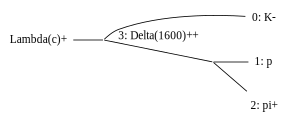

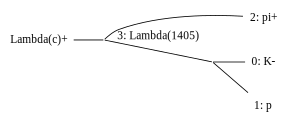

In [ ]:
reaction_two_resonances = qrules.generate_transitions(
    initial_state="Lambda(c)+",
    final_state=["K-", "p", "pi+"],
    formalism="helicity",
    allowed_intermediate_particles=["Lambda(1405)", "Delta(1600)++"],
    particle_db=MODIFIED_PDG,
)
assert len(reaction_two_resonances.transition_groups) == 2
dot = qrules.io.asdot(reaction, collapse_graphs=True)
display(
    *[
        graphviz.Source(
            qrules.io.asdot(
                g, collapse_graphs=True, size=4, render_resonance_id=True
            )
        )
        for g in reaction_two_resonances.transition_groups
    ]
)

In [ ]:
formulate_intensity(reaction_two_resonances).cleanup()

PoolSum(Abs(PoolSum(WignerD(1/2, lambda, lambda_3, -phi_01, theta_01, 0)*WignerD(1/2, lambda_3, -lambda_1, -phi_0^01, theta_0^01, 0) + WignerD(1/2, lambda, lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1, -phi_1^12, theta_1^12, 0), (lambda_3, (-1/2, 1/2))))**2, (lambda, (-1/2, 1/2)), (lambda_1, (-1/2, 1/2)))

In [ ]:
ampform_expr = (
    ampform.get_builder(reaction_two_resonances).formulate().expression
)
ampform_expr = remove_coefficients(ampform_expr)
sum_expr = formulate_intensity(reaction_two_resonances)
assert ampform_expr.doit() == sum_expr.doit()

### Inserting coefficients

There is a problem, though: the sums above could be written in sum form because the values over which we sum appear as arguments ({attr}`~sympy.core.basic.Basic.args` in the {class}`~sympy.physics.quantum.spin.WignerD` functions). This is only true because we previously set all coefficients to $1$. The coefficient _names_ are, however, also 'dependent' on the helicities in the final state over which we sum:

In [ ]:
list(model.parameter_defaults)

[C_{\Lambda_{c}^{+} \to \Delta_{-1/2} K^{-}_{0}; \Delta \to p_{+1/2} \pi^{+}_{0}},
 C_{\Lambda_{c}^{+} \to \Delta_{+1/2} K^{-}_{0}; \Delta \to p_{+1/2} \pi^{+}_{0}}]

We therefore have to somehow introduce a dependence in these {class}`~sympy.core.symbol.Symbol`s on the helicity values.  An idea may be to use {class}`~sympy.tensor.indexed.IndexedBase`. Modifying the function introduced in {ref}`tr-014-solution-1`:

In [ ]:
C = sp.IndexedBase("C")


@lru_cache(maxsize=None)
def formulate_intensity_with_coefficient(reaction: ReactionInfo):
    amplitudes = {
        sp.Mul(
            C[
                [
                    create_helicity_symbol(transition.topology, state_id)
                    for state_id in transition.final_states
                ]
            ],
            *[
                formulate_wigner_d(transition, node_id)
                for node_id in transition.topology.nodes
            ],
        )
        for transition in reaction.transitions
    }
    inner_helicities = get_helicities(reaction, which="inner")
    outer_helicities = get_helicities(reaction, which="outer")
    return PoolSum(
        sp.Abs(
            PoolSum(
                sum(amplitudes),
                *inner_helicities.items(),
            )
        )
        ** 2,
        *outer_helicities.items(),
    )


indexed_coefficient_expr = formulate_intensity_with_coefficient(reaction)
indexed_coefficient_expr

PoolSum(Abs(PoolSum(C[lambda_0, lambda_1, lambda_2]*WignerD(1/2, lambda, -lambda_0 + lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1 - lambda_2, -phi_1^12, theta_1^12, 0), (lambda_3, (-1/2, 1/2))))**2, (lambda, (-1/2, 1/2)), (lambda_0, (0,)), (lambda_1, (-1/2, 1/2)), (lambda_2, (0,)))

In [ ]:
latex = sp.multiline_latex(I, indexed_coefficient_expr.doit(deep=False))
Math(latex)

<IPython.core.display.Math object>

:::{admonition} Caveat

Using {class}`~sympy.tensor.indexed.IndexedBase` makes the coefficient names concise, but harder to understand.

:::

This seems to work rather well, but there is a subtle problems introduced by writing the coefficients as a {class}`~sympy.tensor.indexed.IndexedBase`: the {class}`~sympy.tensor.indexed.IndexedBase` itself is considered listed under the {attr}`~sympy.core.basic.Basic.free_symbols` of the expression.

In [ ]:
free_symbols = sorted(indexed_coefficient_expr.doit().free_symbols, key=str)
free_symbols

[C, C[0, -1/2, 0], C[0, 1/2, 0], phi_12, phi_1^12, theta_12, theta_1^12]

In addition, not all symbols in the expression are of type {class}`~sympy.core.symbol.Symbol` anymore:

In [ ]:
{s: (type(s), isinstance(s, sp.Symbol)) for s in free_symbols}

{C: (sympy.core.symbol.Symbol, True),
 C[0, -1/2, 0]: (sympy.tensor.indexed.Indexed, False),
 C[0, 1/2, 0]: (sympy.tensor.indexed.Indexed, False),
 phi_12: (sympy.core.symbol.Symbol, True),
 phi_1^12: (sympy.core.symbol.Symbol, True),
 theta_12: (sympy.core.symbol.Symbol, True),
 theta_1^12: (sympy.core.symbol.Symbol, True)}

This will become problematic when lambdifying, because it results in an additional argument in the signature of the generated function:

In [ ]:
func = sp.lambdify(free_symbols, indexed_coefficient_expr.doit())
inspect.signature(func)

<Signature (C, Dummy_24, Dummy_23, phi_12, Dummy_26, theta_12, Dummy_25)>

A solution may be to use [`symplot.substitute_indexed_symbols()`](https://ampform.readthedocs.io/en/0.12.3/usage/symplot.html#symplot.substitute_indexed_symbols):

In [ ]:
indexed_coefficient_expr_symbols_only = symplot.substitute_indexed_symbols(
    indexed_coefficient_expr.doit()
)
indexed_coefficient_expr_symbols_only.free_symbols

{C_{0,-1/2,0}, C_{0,1/2,0}, phi_12, phi_1^12, theta_12, theta_1^12}

In [ ]:
args = sorted(indexed_coefficient_expr_symbols_only.free_symbols, key=str)
func = sp.lambdify(args, indexed_coefficient_expr_symbols_only)
inspect.signature(func)

<Signature (Dummy_30, Dummy_29, phi_12, Dummy_28, theta_12, Dummy_27)>

:::{admonition} Caveat

This seems clumsy, because [`substitute_indexed_symbols()`](https://ampform.readthedocs.io/en/0.12.3/usage/symplot.html#symplot.substitute_indexed_symbols) would have to be actively called before creating a computational function with [TensorWaves](https://tensorwaves.rtfd.io). It also becomes a hassle to keep track of the correct {class}`~sympy.core.symbol.Symbol` names in [`HelicityModel.parameter_defaults`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.helicity.html#ampform.helicity.HelicityModel.parameter_defaults).

:::

In [ ]:
# One topology
expr = ampform.get_builder(reaction).formulate().expression
expr = remove_coefficients(expr.doit())
sum_expr = formulate_intensity_with_coefficient(reaction)
sum_expr = symplot.substitute_indexed_symbols(sum_expr.doit())
sum_expr = remove_coefficients(sum_expr)
assert sum_expr == expr

# Two topologies
expr = ampform.get_builder(reaction_two_resonances).formulate().expression
expr = remove_coefficients(expr.doit())
sum_expr = formulate_intensity_with_coefficient(reaction_two_resonances)
sum_expr = symplot.substitute_indexed_symbols(sum_expr.doit())
sum_expr = remove_coefficients(sum_expr)
assert sum_expr == expr

### Inserting dynamics

Dynamics pose a challenge that is similar to {ref}`report/014:Inserting coefficients` in that we have to introduce expressions that are dependent on spin. Still, as can be seen from the available attributes on a [`TwoBodyKinematicVariableSet`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.dynamics.builder.html#ampform.dynamics.builder.TwoBodyKinematicVariableSet) (which serves as input to [`ResonanceDynamicsBuilder`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.dynamics.builder.html#ampform.dynamics.builder.ResonanceDynamicsBuilder)s), dynamics (currently) cannot depend on helicities.

What may become a problem are $LS$-combinations. So far we have only considered a [`ReactionInfo`](https://qrules.readthedocs.io/en/0.9.6/api/qrules.transition.html#qrules.transition.ReactionInfo) that was created with `formalism="helicity"`, but we also have to sum over $LS$-combinations when using `formalism="canonical-helicity"`. This is particularly important when using dynamics with form factors, which depend on [`angular_momentum`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.dynamics.builder.html#ampform.dynamics.builder.TwoBodyKinematicVariableSet.angular_momentum).


:::{note}

The {class}`sympy.tensor.indexed.Indexed` now also contains the names of the resonances.

:::

In [ ]:
def formulate_intensity_with_dynamics(
    reaction: ReactionInfo,
    dynamics_choices: dict[str, ResonanceDynamicsBuilder],
):
    amplitudes = set()
    for transition in reaction.transitions:
        final_state_helicities = [
            create_helicity_symbol(transition.topology, state_id)
            for state_id in transition.final_states
        ]
        resonances = [
            Str(s.particle.latex)
            for s in transition.intermediate_states.values()
        ]
        indices = [*final_state_helicities, *resonances]
        coefficient = C[indices]
        expr: sp.Expr = coefficient
        for node_id in sorted(transition.topology.nodes):
            expr *= formulate_wigner_d(transition, node_id)
            decay = TwoBodyDecay.from_transition(transition, node_id)
            parent_particle = decay.parent.particle
            dynamics_builder = dynamics_choices.get(
                parent_particle.name, create_non_dynamic
            )
            variables = _generate_kinematic_variable_set(transition, node_id)
            dynamics, _ = dynamics_builder(parent_particle, variables)
            expr *= dynamics
        amplitudes.add(expr)
    inner_helicities = get_helicities(reaction, which="inner")
    outer_helicities = get_helicities(reaction, which="outer")
    return PoolSum(
        sp.Abs(
            PoolSum(sum(amplitudes), *inner_helicities.items()),
            evaluate=False,
        )
        ** 2,
        *outer_helicities.items(),
    )

In [ ]:
formulate_intensity_with_dynamics(
    reaction,
    dynamics_choices={
        resonance.name: create_relativistic_breit_wigner
        for resonance in reaction.get_intermediate_particles()
    },
)

PoolSum(Abs(PoolSum(\Gamma_{\Delta}*m_{\Delta}*C[lambda_0, lambda_1, lambda_2, \Delta]*WignerD(1/2, lambda, -lambda_0 + lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1 - lambda_2, -phi_1^12, theta_1^12, 0)/(-I*\Gamma_{\Delta}*m_{\Delta} - m_12**2 + m_{\Delta}**2), (lambda_3, (-1/2, 1/2))))**2, (lambda, (-1/2, 1/2)), (lambda_0, (0,)), (lambda_1, (-1/2, 1/2)), (lambda_2, (0,)))

In [ ]:
formulate_intensity_with_dynamics(
    reaction_two_resonances,
    dynamics_choices={
        resonance.name: create_relativistic_breit_wigner
        for resonance in reaction_two_resonances.get_intermediate_particles()
    },
)

PoolSum(Abs(PoolSum(\Gamma_{\Delta}*m_{\Delta}*C[lambda_0, lambda_1, lambda_2, \Delta]*WignerD(1/2, lambda, -lambda_0 + lambda_3, -phi_12, theta_12, 0)*WignerD(3/2, lambda_3, lambda_1 - lambda_2, -phi_1^12, theta_1^12, 0)/(-I*\Gamma_{\Delta}*m_{\Delta} - m_12**2 + m_{\Delta}**2) + \Gamma_{\Lambda}*m_{\Lambda}*C[lambda_0, lambda_1, lambda_2, \Lambda]*WignerD(1/2, lambda, -lambda_2 + lambda_3, -phi_01, theta_01, 0)*WignerD(1/2, lambda_3, lambda_0 - lambda_1, -phi_0^01, theta_0^01, 0)/(-I*\Gamma_{\Lambda}*m_{\Lambda} - m_01**2 + m_{\Lambda}**2), (lambda_3, (-1/2, 1/2))))**2, (lambda, (-1/2, 1/2)), (lambda_0, (0,)), (lambda_1, (-1/2, 1/2)), (lambda_2, (0,)))

The resulting amplitude is again identical to the original [`HelicityModel.expression`](https://ampform.readthedocs.io/en/stable/api/ampform.helicity.html#ampform.helicity.HelicityModel.expression):

In [ ]:
# One topology
b = ampform.get_builder(reaction)
for p in reaction.get_intermediate_particles():
    b.set_dynamics(p.name, create_relativistic_breit_wigner)
expr = b.formulate().expression
expr = remove_coefficients(expr.doit())
sum_expr = formulate_intensity_with_dynamics(
    reaction,
    dynamics_choices={
        resonance.name: create_relativistic_breit_wigner
        for resonance in reaction.get_intermediate_particles()
    },
)
sum_expr = symplot.substitute_indexed_symbols(sum_expr.doit())
sum_expr = remove_coefficients(sum_expr)
assert sum_expr == expr

# Two topologies
b = ampform.get_builder(reaction_two_resonances)
for p in reaction_two_resonances.get_intermediate_particles():
    b.set_dynamics(p.name, create_relativistic_breit_wigner)
expr = b.formulate().expression
expr = remove_coefficients(expr)
sum_expr = formulate_intensity_with_dynamics(
    reaction_two_resonances,
    dynamics_choices={
        resonance.name: create_relativistic_breit_wigner
        for resonance in reaction_two_resonances.get_intermediate_particles()
    },
)
sum_expr = symplot.partial_doit(sum_expr, doit_classes=(PoolSum,))
sum_expr = symplot.partial_doit(sum_expr, doit_classes=(PoolSum,))  # recurse
sum_expr = symplot.substitute_indexed_symbols(sum_expr)
sum_expr = remove_coefficients(sum_expr)
assert sum_expr.free_symbols == expr.free_symbols
for intensity1, intensity2 in zip(sum_expr.args, expr.args):
    # Annoyingly, Abs is rewritten with conjugates when using PoolSum...
    amp1 = intensity1.args[0]
    amp2 = intensity2.rewrite(sp.conjugate).args[0]
    amp1 = sp.factor(amp1, deep=True, fraction=False)
    amp2 = sp.factor(amp2, deep=True, fraction=False)
    assert amp1 == amp2

(tr-014-solution-2)=
## Solution 2: `Indexed` amplitude components

The main problem with {ref}`tr-014-solution-2` is that it requires changing coefficient {class}`~sympy.core.symbol.Symbol`s to instances of {class}`~sympy.tensor.indexed.Indexed`, which have to be substituted using [`substitute_indexed_symbols()`](https://ampform.readthedocs.io/en/0.12.3/usage/symplot.html#symplot.substitute_indexed_symbols) (**after** calling {meth}`~sympy.core.basic.Basic.doit`).

An alternative would be insert dynamics (and coefficients) into the `PoolSum`s over the helicities is to index the amplitude itself. The [`HelicityModel.expression`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.helicity.html#ampform.helicity.HelicityModel.expression) would then contain {class}`~sympy.tensor.indexed.Indexed` symbols that represent specific amplitudes. A definition of these amplitudes can be provided through [`HelicityModel.components`](https://ampform.readthedocs.io/en/0.12.3/api/ampform.helicity.html#ampform.helicity.HelicityModel.components) or an equivalent attribute.

In [ ]:
from ampform.helicity.naming import HelicityAmplitudeNameGenerator

A = sp.IndexedBase(R"\mathcal{A}")


def formulate_intensity_indexed_amplitudes_only(
    reaction: ReactionInfo,
    dynamics_choices: dict[str, ResonanceDynamicsBuilder],
) -> tuple[sp.Expr, dict[sp.Indexed, sp.Expr]]:
    name_generator = HelicityAmplitudeNameGenerator()
    amplitudes = set()
    amplitude_definitions = {}
    for transition in reaction.transitions:
        name_generator.register_amplitude_coefficient_name(transition)
    for transition in reaction.transitions:
        suffix = name_generator.generate_sequential_amplitude_suffix(
            transition
        )
        expr: sp.Expr = sp.Symbol(f"C_{{{suffix}}}")
        for node_id in sorted(transition.topology.nodes):
            expr *= ampform.helicity.formulate_wigner_d(transition, node_id)
            decay = TwoBodyDecay.from_transition(transition, node_id)
            parent_particle = decay.parent.particle
            dynamics_builder = dynamics_choices.get(
                parent_particle.name, create_non_dynamic
            )
            variables = _generate_kinematic_variable_set(transition, node_id)
            dynamics, _ = dynamics_builder(parent_particle, variables)
            expr *= dynamics
        resonances = [
            Str(s.particle.latex)
            for s in transition.intermediate_states.values()
        ]
        helicity_symbols = [
            create_helicity_symbol(transition.topology, state_id)
            for state_id in sorted(transition.states)
        ]
        helicities = [
            sp.Rational(transition.states[state_id].spin_projection)
            for state_id in sorted(transition.states)
        ]
        amplitudes.add(A[[*helicity_symbols, *resonances]])
        amplitude_definitions[A[[*helicities, *resonances]]] = expr
    inner_helicities = get_helicities(reaction, which="inner")
    outer_helicities = get_helicities(reaction, which="outer")
    expression = PoolSum(
        sp.Abs(
            PoolSum(sum(amplitudes), *inner_helicities.items()),
            evaluate=False,
        )
        ** 2,
        *outer_helicities.items(),
    )
    return expression, amplitude_definitions

In [ ]:
expression, amplitudes = formulate_intensity_indexed_amplitudes_only(
    reaction_two_resonances,
    dynamics_choices={
        resonance.name: create_relativistic_breit_wigner
        for resonance in reaction_two_resonances.get_intermediate_particles()
    },
)

In [ ]:
display(Math(sp.multiline_latex(I, expression)))
display(Math(sp.multiline_latex(I, expression.doit())))
for i, (symbol, expr) in enumerate(amplitudes.items(), 1):
    latex = sp.multiline_latex(symbol, expr)
    display(Math(latex))
    if i == 3:
        break

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$\dots$

The resulting amplitude is indeed identical to the original [`HelicityModel.expression`](https://ampform.readthedocs.io/en/stable/api/ampform.helicity.html#ampform.helicity.HelicityModel.expression):

In [ ]:
b = ampform.get_builder(reaction_two_resonances)
for resonance in reaction_two_resonances.get_intermediate_particles():
    b.set_dynamics(resonance.name, create_relativistic_breit_wigner)
model_two_res = b.formulate()

assert model_two_res.expression == expression.doit().xreplace(amplitudes)

:::{tip}

Currently, amplitudes with different resonances are put under a different amplitude symbol, identified by that resonance. Such resonances can be combined, e.g. $\mathcal{A}_{\lambda_i} = \mathcal{A}_{\lambda_i,\Delta} + \mathcal{A}_{\lambda_i,\Lambda}$. This would also make it easier to introduce correct interference terms through the [$K$-matrix](https://ampform.readthedocs.io/en/0.12.3/usage/dynamics/k-matrix.html).

:::

:::{admonition} Question

The helicity of the intermediate state is also passed to the indexed amplitude. This is required for the coefficient name, which has a helicity subscript for the intermediate state, e.g. $C_{\Lambda_{c}^{+} \to \Lambda_{\color{red}+1/2} \pi^{+}_{0}; \Lambda \to K^{-}_{0} p_{+1/2}}$. Does it really make sense to distinguish coefficients for different helicities of intermediate states?

:::